In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter


import nltk
#nltk.download('stopwords') # Added (requested by system)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

import numpy as np

stop_words = stopwords.words('english')

### Preprocess data

In [9]:
df = pd.read_parquet('data/dataset_1month.gzip')

In [10]:
df["date"] = df["date"].apply(lambda d:  datetime.fromisoformat(d[:-1]))
df["date"] = df["date"].apply(lambda d:  d - timedelta(minutes=d.minute,seconds=d.second,microseconds=d.microsecond))


In [11]:
df["text"] = df["text"].apply(lambda t: t.lower())
df["title"] = df["title"].apply(lambda t: t.lower())

In [1]:
df.to_parquet('data/dataset_1month_processed.gzip',compression='gzip')  

NameError: name 'df' is not defined

In [ ]:
display, test = train_test_split(df, test_size=0.2)

In [ ]:
test.to_parquet('data/dataset_1month_processed_subset.gzip',compression='gzip')  

### Try out diffrent (meta)data to plot for same articles to see which one is the cleaner

In [180]:
df = pd.read_parquet("data/dataset_1month_processed.gzip")

In [181]:
def plot_number_article(dataframe): 
    result = dataframe.groupby("date").count().sort_values("date")
    plt.figure(figsize = (15, 5))


    plt.plot(result.index.values,result["handle"] , 'b')

    # Decorate
    plt.xlabel('date')
    plt.ylabel('count article')

    plt.title('Number articles per hours')
    plt.show()

In [182]:
def plot_number_reaction(dataframe):
    result1 = dataframe.groupby("date").sum().sum(axis=1)
    
    plt.figure(figsize = (15, 5))


    plt.plot(result1.index.values,result1 , 'b')

    # Decorate
    plt.xlabel('date')
    plt.ylabel('count reactions')

    plt.title('Number of reactions per hours')
    plt.show()

In [183]:
def plot__number_reaction_x_number_article(dataframe):
    result = dataframe.groupby("date").count().sort_values("date")["handle"]
    result1 = dataframe.groupby("date").sum().sum(axis=1)
    result2 = result * result1
    
    plt.figure(figsize = (15, 5))


    plt.plot(result2.index.values,result2 , 'b')

    # Decorate
    plt.xlabel('date')
    plt.ylabel('reactions * number of articles')

    plt.title('Reactions * number of articles per hour')
    plt.show()

In [184]:
def plot_number_handle(dataframe):
    plt.figure(figsize = (15, 5))

    result = dataframe.groupby("date")["handle"].nunique()

    plt.plot(result.index.values,result, 'b')

    # Decorate
    plt.xlabel('date')
    plt.ylabel('Number of handle')

    plt.title('Number of handle per hour')
    plt.show()

In [185]:
def plot_scaled_reaction(dataframe):
    dataframe['total_reaction'] = dataframe["quotes"] + dataframe["retweets"] + dataframe["favorites"] + dataframe["replies"]
    dataframe['handle_max'] = dataframe['total_reaction'].groupby(dataframe['handle']).transform('max')
    dataframe["scaled_reactions"] = dataframe["total_reaction"] / dataframe["handle_max"]
    plt.figure(figsize = (15, 5))

    result = dataframe.groupby("date").sum().sort_values("date")["scaled_reactions"]

    plt.plot(result.index.values,result , 'b')

    # Decorate
    plt.xlabel('date')
    plt.ylabel('sum of scaled reaction')

    plt.title('sum of scaled reaction per hour')
    plt.show()

In [186]:
def plot_graphs_per_hour(dataframe):
    plot_number_article(dataframe)
    plot_number_reaction(dataframe)
    plot_number_handle(dataframe)
    plot_scaled_reaction(dataframe) # ! Modify dataframe
    plot__number_reaction_x_number_article(dataframe)

In [187]:
def filter_search_term(df, search_term):
    search_term = search_term.lower()
    return df[df['text'].str.contains(search_term) | df['title'].str.contains(search_term)]
   

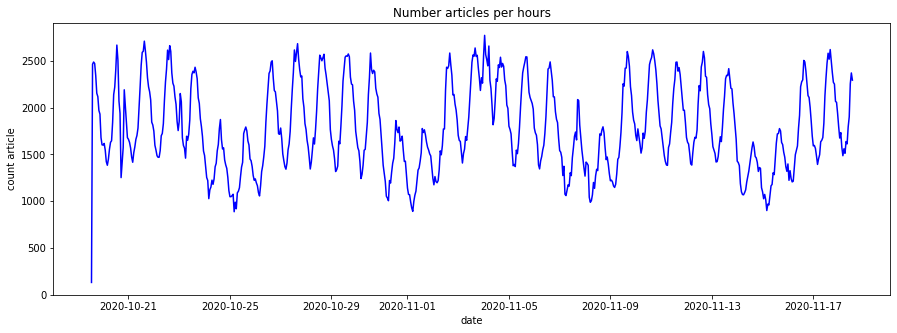

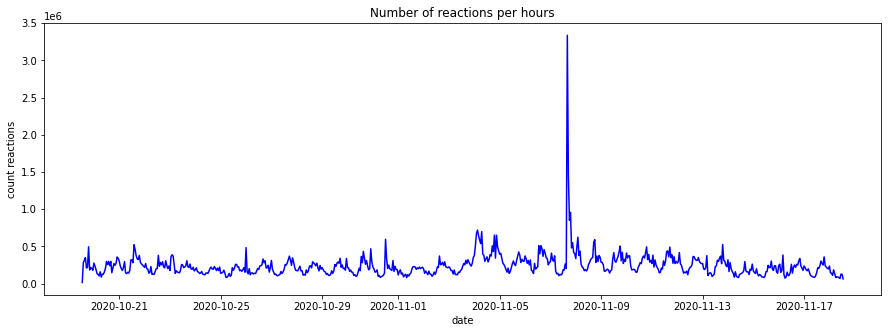

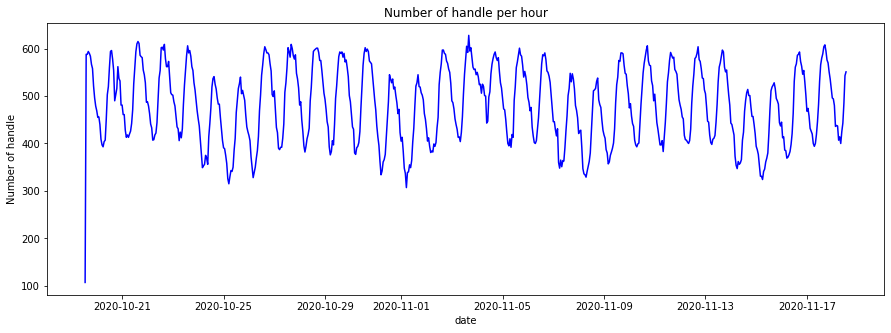

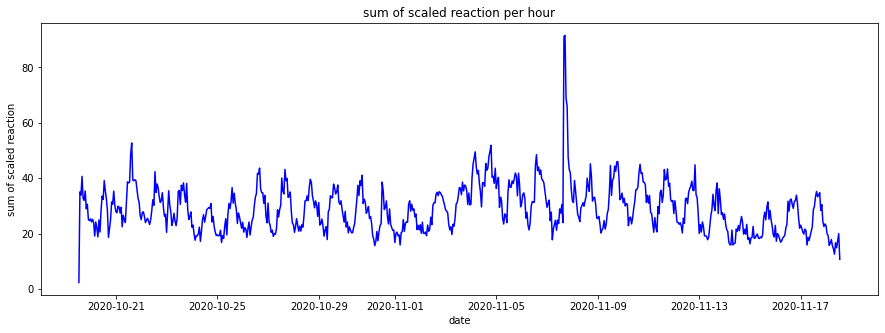

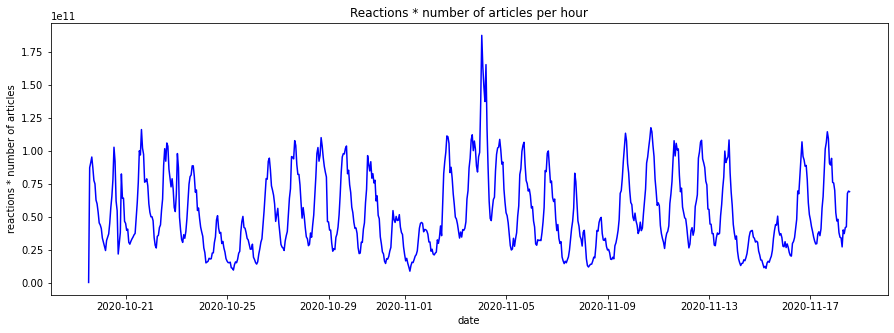

In [188]:
plot_graphs_per_hour(df)

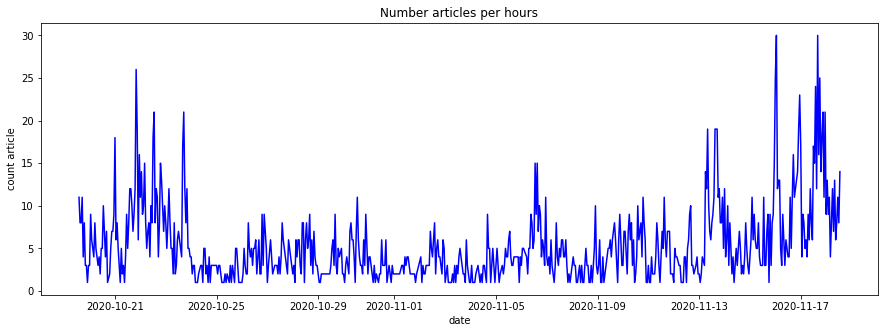

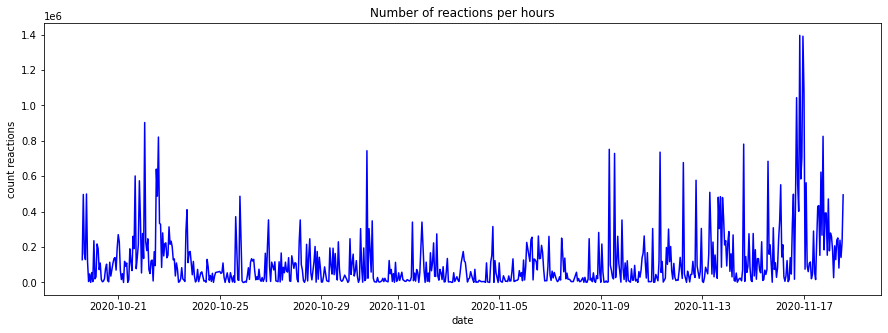

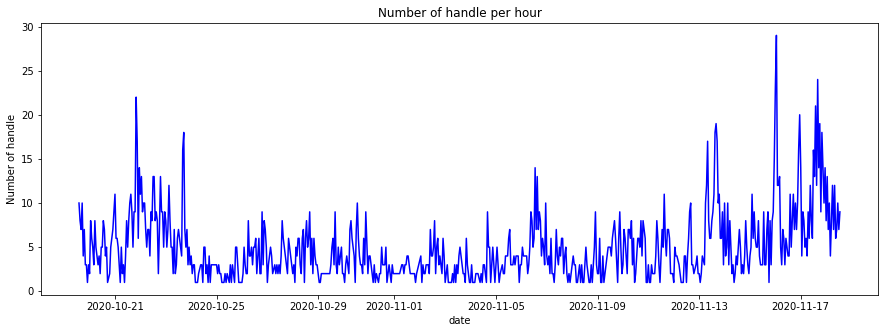

<ipython-input-185-27a3d342ae9d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['total_reaction'] = dataframe["quotes"] + dataframe["retweets"] + dataframe["favorites"] + dataframe["replies"]
<ipython-input-185-27a3d342ae9d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['handle_max'] = dataframe['total_reaction'].groupby(dataframe['handle']).transform('max')
<ipython-input-185-27a3d342ae9d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

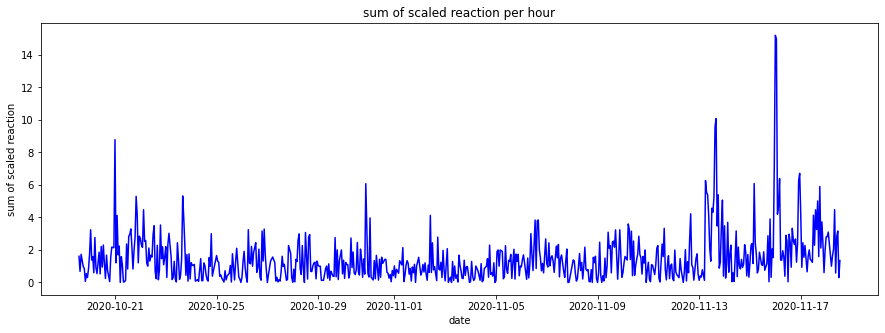

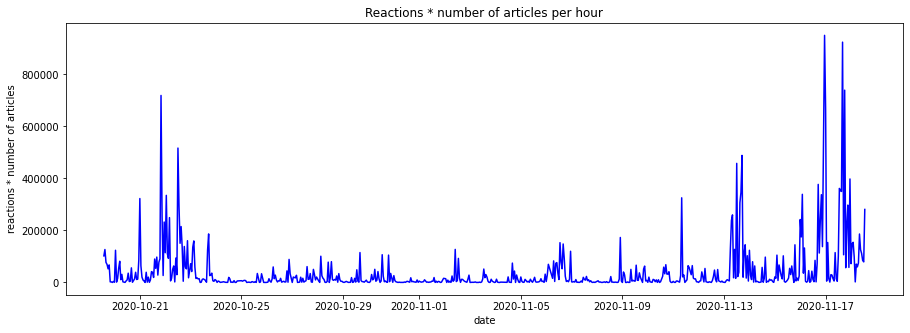

In [189]:
plot_graphs_per_hour(filter_search_term(df, "tesla"))

### Get most frequent words

In [2]:
data = pd.read_parquet("data/dataset_1month_processed_subset.gzip")

In [4]:
def preprocess(sentence, max_words=100):
    sentence = sentence.lower()
    
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    word_tokens = tokenizer.tokenize(sentence)
  
    filtered_sentence = [w for w in word_tokens if not w in stop_words][:max_words]
  
    return " ".join(filtered_sentence)

In [5]:
data = data[data["lang"]=="en"]
data['preproc'] = (data['title'] +  " " + data['text']).apply(preprocess)

<ipython-input-5-4d286aca0578>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['preproc'] = (data['title'] +  " " + data['text']).apply(preprocess)


In [23]:
words = (data["preproc"]
           .str.cat(sep=' ')
           .split())

rslt = pd.DataFrame(Counter(words).most_common(25000),
                    columns=['Word', 'Frequency']).set_index('Word')
print(rslt)

             Frequency
Word                  
said            107187
trump            67178
new              59440
election         53165
president        50118
...                ...
burj                30
729                 30
sustainably         30
lol                 30
yamuna              30

[25000 rows x 1 columns]


In [11]:
#rslt.to_parquet('data/25kwords.gzip',compression='gzip')  

### Get most frequent nouns using Spacy - took at least one hour on my computer

In [6]:
import spacy

In [19]:
nlp = spacy.load('en_core_web_sm')

def preproc_to_noun(preproc):
    doc = nlp(preproc)

    nouns = []
    for token in doc:
        if(token.tag_ == "NNP"):
            nouns.append(token.text)
    return nouns

In [20]:
data['nouns'] = data['preproc'].apply(preproc_to_noun)

<ipython-input-20-81d6a759108c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['nouns'] = data['preproc'].apply(preproc_to_noun)


In [24]:
data.to_parquet('data/dataset_1month_processed_with_nouns.gzip',compression='gzip')  

In [2]:
data = pd.read_parquet('data/dataset_1month_processed_with_nouns.gzip')

In [3]:
data['nouns']

1099345    [michael, b, jordan, thriller, paramount, mich...
1273830    [us, security, u, president, donald, trump, re...
649093     [democrat, republican, stronghold, oregon, ark...
523066     [nigel, farage, rebrand, brexit, party, corona...
661925     [vp, protest, comelec, mindanao, request, answ...
                                 ...                        
809157     [deal, lifetime, manslaughter, charge, settle,...
723017     [white, house, president, trump, thursday, geo...
60704      [nyc, transit, covid, new, york, city, wabc, n...
339323     [sydney, daily, telegraph, enable, browser, fa...
790735     [president, buhari, nation, nigeria, ooni, ife...
Name: nouns, Length: 150909, dtype: object

In [4]:
words = [noun for sublist in data['nouns'] for noun in sublist]

wordFreqSpacy = pd.DataFrame(Counter(words).most_common(25000), columns=['Word', 'Frequency']).set_index('Word')
print(wordFreqSpacy)

             Frequency
Word                  
president        42377
trump            36587
biden            34787
coronavirus      22443
new              20751
...                ...
impediment           9
lior                 9
cullinane            9
ó                    9
blackwater           9

[25000 rows x 1 columns]


### Create date x handle x words matrix that stores the number of articles

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import coo_matrix 

In [7]:
#wordsFreq = pd.read_parquet('data/25kwords.gzip')

In [6]:
def preprocess(sentence, max_words=100):
    sentence = sentence.lower()
    
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    word_tokens = tokenizer.tokenize(sentence)
  
    filtered_sentence = [w for w in word_tokens if not w in stop_words][:max_words]
  
    return " ".join(filtered_sentence)

In [173]:
def compute_frequency_matrix(df, voc):
    df = df[df["lang"]=="en"]
    df['preproc'] = (df['title'] +  " " + df['text']).apply(preprocess)
    
    print("Data pre-processed")

    count_vect = CountVectorizer(vocabulary= voc)

    def string_to_count(string):
        sparse = count_vect.transform(["",string])[1]
        array = sparse.toarray()[0]
        tupleslist = []
        for i in sparse.nonzero()[1]:
            tupleslist.append((i, array[i]))

        return tupleslist

    r = df.groupby(['date','handle'])["preproc"].agg(' '.join).apply(string_to_count)
    
    print("Words counted")

    r = r.reset_index()
    
    r["handle_id"], handles = r["handle"].factorize()
    r["date_id"], dates = r["date"].factorize()
    
    print("Start computing frequency matrix")

    freqMatrix = np.zeros((len(dates), len(handles), 25000), np.int8)
    for line in r.iloc():
        for (word_index, value) in line["preproc"]:
            freqMatrix[line["date_id"]][line["handle_id"]][word_index] = value
            
    return (freqMatrix, handles, dates)

In [174]:
data = pd.read_parquet("data/dataset_1month_processed_subset.gzip")

In [175]:
(freqMatrix, handles, dates) = compute_frequency_matrix(data, wordFreqSpacy.index.values)

<ipython-input-173-404889b69098>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preproc'] = (df['title'] +  " " + df['text']).apply(preprocess)


Data pre-processed
Words counted
Start computing frequency matrix


### Try to find interesting sparklines

In [159]:
def plot_best_words(matrix,shift, top_words_index, words, dates, data):
    for word_idx, date_idx in top_words_index:
        plot_freq_words_per_date(matrix, (word_idx,date_idx + shift), words[word_idx], dates, data)

In [160]:
def plot_freq_words_per_date(matrix, index, word, dates, data): 
    (word_idx, date_idx) = index
    x, y, z = matrix.shape
    result = matrix[:,:,word_idx].reshape(x,-1).sum(axis=1)
    plt.figure(figsize = (15, 5))

    plt.plot(dates,result, 'b')

    # Decorate
    plt.xlabel('date')
    plt.ylabel('Number of articles')
    plt.title( f"Number of articles with '{word}' per hours")
    plt.show()
    
    print(f"best pic at: {dates[date_idx]} with {result[date_idx]} apparitions")


    related_articles = get_related_articles(data, dates[date_idx], word)
    display_articles = related_articles[:3]
    for index, row in display_articles.iterrows():
        print(row["handle"], " - ", row['title'])

In [29]:
def get_related_articles(data, date, word):
    rslt = data[(data["date"] == date) & (data["text"].str.contains(word) | data["title"].str.contains(word))]
    return rslt

### Display top sparkline using different methods

In [176]:
# Using most frequent words
#words = wordsFreq.index.values
#matrix = freqMatrix

# Using most frequent nouns from Spacy
words = wordFreqSpacy.index.values
matrix = freqMatrix

# Last hour
#nbr_of_hours = 1

# Last day
nbr_of_hours = 24

# Last week
#nbr_of_hours = 24 * 7

# Last month
#nbr_of_hours = 24 * 7 * 30 # All months don't have the same length, but not my problem

nbr_of_hours = min(nbr_of_hours, matrix.shape[0])

shift = matrix.shape[0]-nbr_of_hours
arr = matrix[-nbr_of_hours:,:,:]   

#### Display sparklines with steepest pic - not the best results

In [165]:
def get_word_idx_with_best_diff(arr, numberOfWords):
    diff_arr = (arr[1:,:,:] - arr[:-1,:,:])
    
    words_dateTime = np.transpose(arr, (2, 0, 1)).sum(axis=2)
    
    # get index of best diff for each word
    best_idx = words_dateTime.argmax(1) 

    # get corresponding values (diff in arr)
    values = [words_dateTime[word_idx,max_idx]for word_idx,max_idx in enumerate(best_idx)]

    best_words_index = np.array(values).argsort()[::-1][:min(numberOfWords, len(values))]
    word_and_best_datetime_idx = [(idx,best_idx[idx] + 1) for idx in best_words_index]
    
    return word_and_best_datetime_idx 

In [166]:
top_words_index = get_word_idx_with_best_diff(arr, 100)

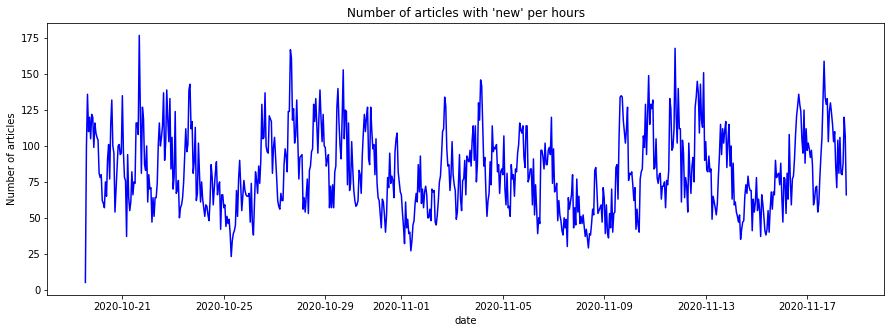

best pic at: 2020-11-17 17:00:00 with 134 apparitions
ABCPolitics  -  twitter: 300,000 tweets flagged over election disinformation
News24  -  maths paper 2 leak: eff in gauteng condemns 'acts of criminality', tells pupils to remain focused
TheBuffaloNews  -  state moves start of high school winter sports to jan. 4


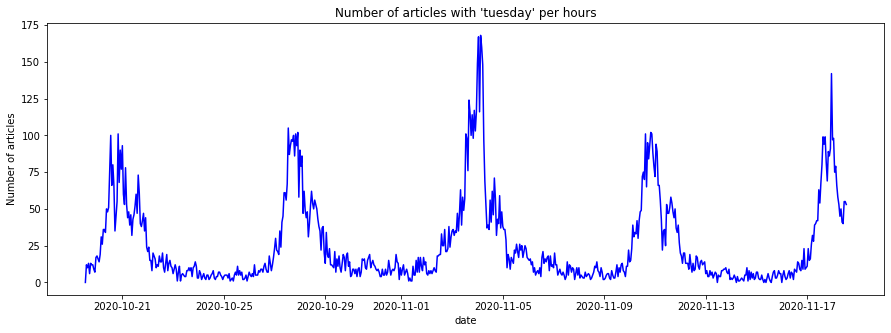

best pic at: 2020-11-18 00:00:00 with 97 apparitions
DEADLINE  -  donald trump fires top homeland security official who refuted claims of voter fraud
JamaicaGleaner  -  pm details $1 billion road improvement programme
sfchronicle  -  president-elect biden picked this bay area doctor to serve on his covid task force. here's why


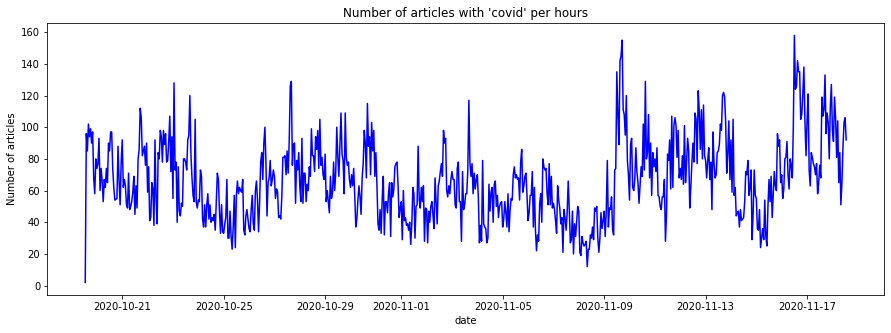

best pic at: 2020-11-17 18:00:00 with 96 apparitions
CBSNews  -  watch live: pennsylvania secretary of health announces "targeted efforts" to control covid-19 spread
CTVNews  -  encouraging data from covid-19 vaccines won't prevent a dangerous stretch of rising cases, experts warn
EastBayTimes  -  not so cool, keanu: reeves caught in covid-19 party scandal — like the kardashians and gavin newsom


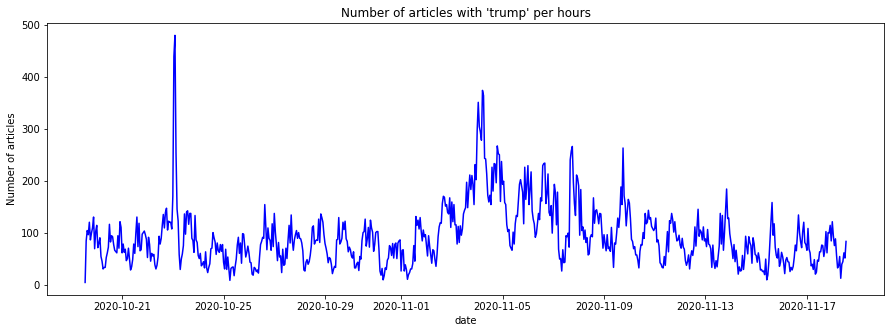

best pic at: 2020-11-18 01:00:00 with 94 apparitions
BrookingsInst  -  who will hold the most power in the next senate?
BreitbartNews  -  ron perlman: 'i feel like lindsey graham is ripe for an a** f**king'
WashTimes  -  assassination by israeli agents exposes iran’s links to al qaeda


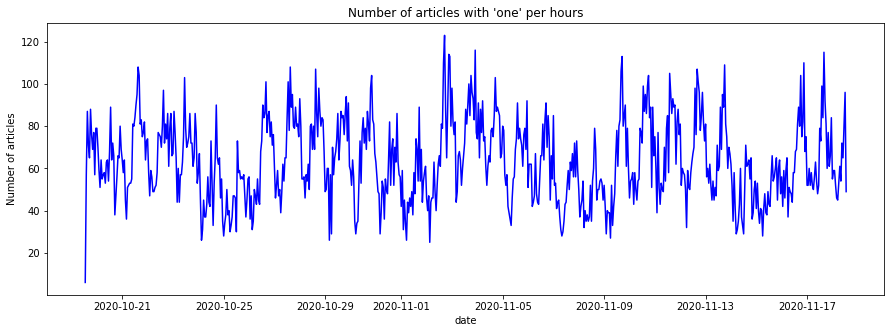

best pic at: 2020-11-17 17:00:00 with 92 apparitions
ABCPolitics  -  twitter: 300,000 tweets flagged over election disinformation
News24  -  maths paper 2 leak: eff in gauteng condemns 'acts of criminality', tells pupils to remain focused
DailyMirror  -  'i was so angry inside' - bereaved mum opens up on agony of losing her baby girl


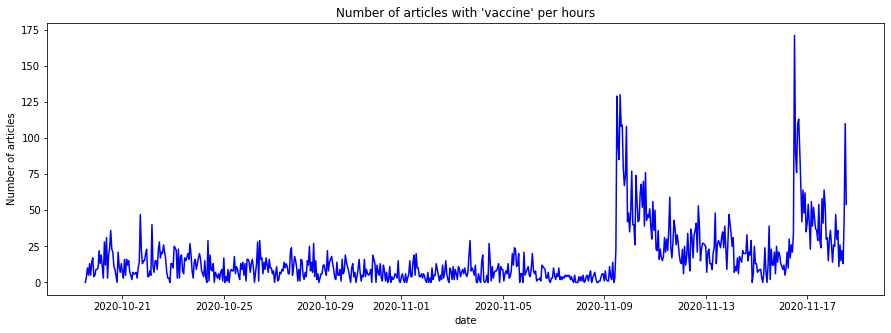

best pic at: 2020-11-18 13:00:00 with 54 apparitions
EconomicTimes  -  coronavirus vaccine live updates: pfizer ends covid-19 trial with 95% efficacy
nytpolitics  -  denied briefings by trump, biden meets with former national security officials
ReutersWorld  -  q&a: where are we in the covid-19 vaccine race?


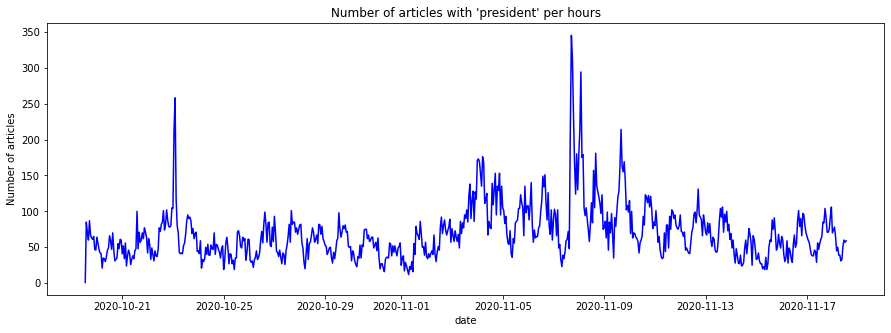

best pic at: 2020-11-18 00:00:00 with 70 apparitions
DEADLINE  -  donald trump fires top homeland security official who refuted claims of voter fraud
ForeignPolicy  -  trump’s defeat was world historic
sfchronicle  -  president-elect biden picked this bay area doctor to serve on his covid task force. here's why


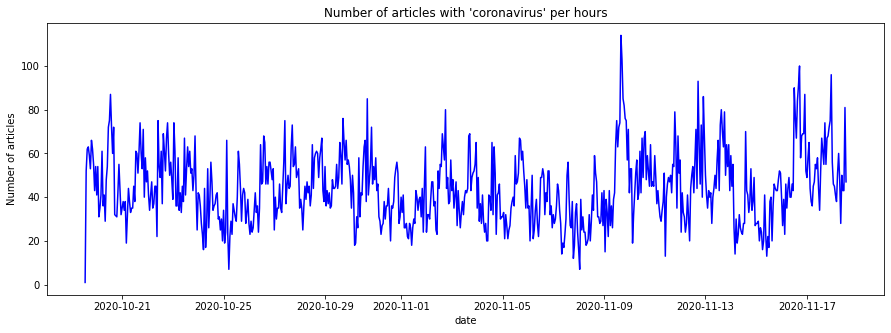

best pic at: 2020-11-18 00:00:00 with 56 apparitions
ForeignPolicy  -  trump’s defeat was world historic
sfchronicle  -  president-elect biden picked this bay area doctor to serve on his covid task force. here's why
RTDNEWS  -  review: 'big sky' keeps mystery's tension at a horror-film high


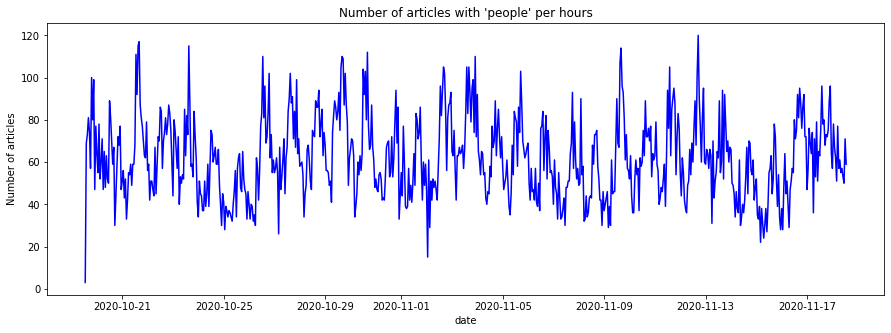

best pic at: 2020-11-17 15:00:00 with 78 apparitions
MetroUK  -  michelle obama lashes out at trump's 'racist lies' about husband
realDailyWire  -  elon musk on verge of passing zuckerberg, becoming world’s 3rd richest man
people  -  wolf van halen on grieving loss of father eddie: you 'figure out how to carry it a bit better'


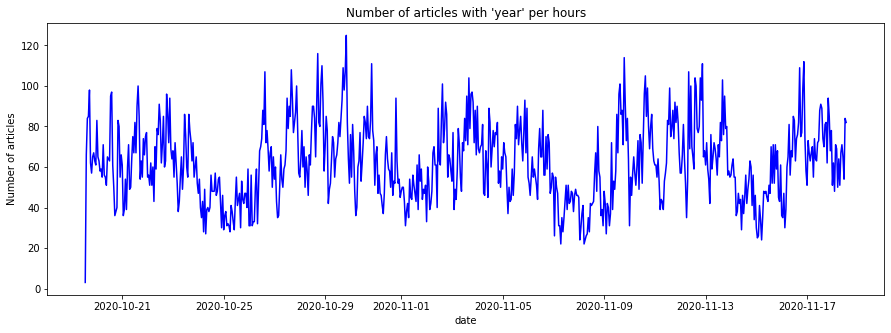

best pic at: 2020-11-17 21:00:00 with 85 apparitions
mercnews  -  new mural kicks off guadalupe river park art project
Reuters  -  j&j expects data for authorization of covid-19 vaccine by february, says head scientist
Poynter  -  while georgia's now on everyone's mind, local political reporters could have told you this was coming


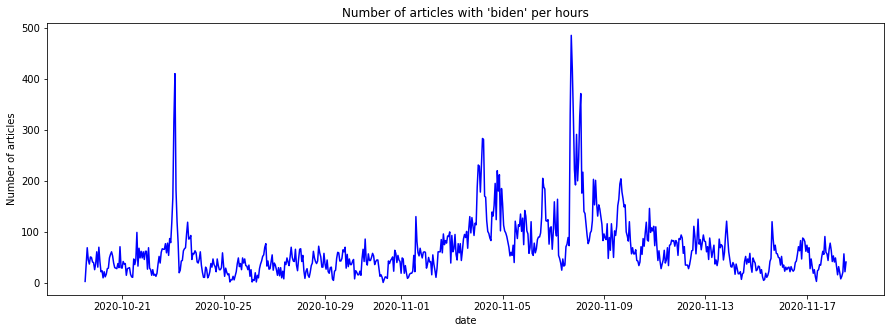

best pic at: 2020-11-17 18:00:00 with 60 apparitions
Newsweek  -  lindsey graham says he discussed election concerns with officials in arizona, nevada—not just georgia
standardnews  -  the trick to saving the planet? pensions, actually
theMRC  -  unhinged cnn: gop hates ‘democracy,’ ‘uncomfortable’ with voters


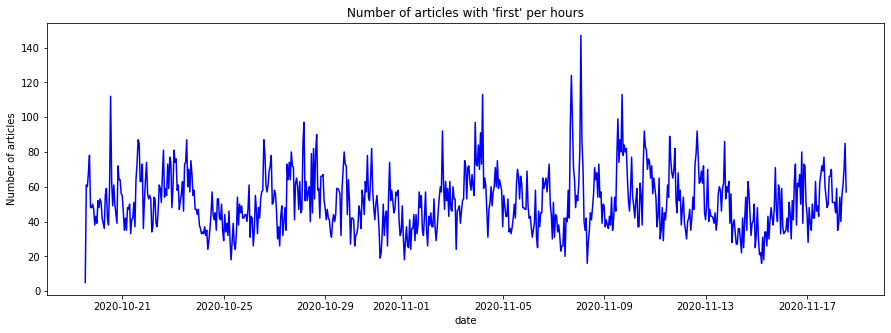

best pic at: 2020-11-18 13:00:00 with 57 apparitions
latimes  -  ice is deporting women at irwin amid criminal investigation into georgia doctor
nytpolitics  -  denied briefings by trump, biden meets with former national security officials
bangordailynews  -  angus king says trump’s firing of cybersecurity head inflicts ‘severe damage’ on country


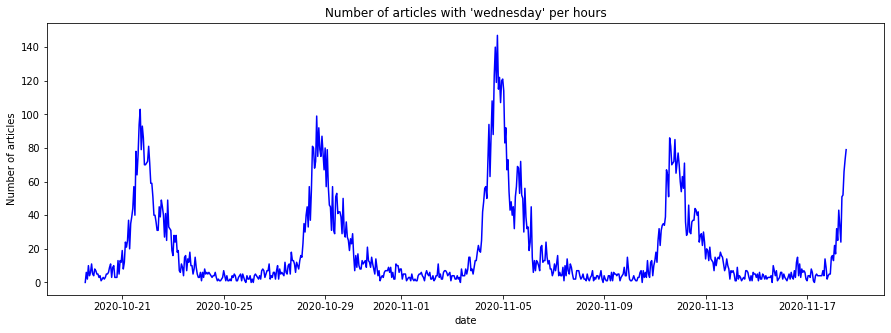

IndexError: index 720 is out of bounds for axis 0 with size 720

In [168]:
plot_best_words(matrix, shift, top_words_index[:50], words, dates, data)

#### Using score = largest pic for a word / max(1, mean for word)

In [177]:
def compute_word_idx_with_best_score(total_arr, sub_arr, numberOfWords):

    words_dateTime_sub = np.transpose(sub_arr, (2, 0, 1)).sum(axis=2)
    words_dateTime_total = np.transpose(total_arr, (2, 0, 1)).sum(axis=2)

    best_idx = words_dateTime_sub.argmax(1) 

    means_word = words_dateTime_total.mean(axis=1)

    values = [words_dateTime_sub[word_idx,max_idx] / max(means_word[word_idx],1) for word_idx,max_idx in enumerate(best_idx)]
    
    best_words_index = np.array(values).argsort()[::-1][:min(numberOfWords, len(values))]
    word_and_best_datetime_idx = [(idx,best_idx[idx]) for idx in best_words_index]
    
    return word_and_best_datetime_idx

In [178]:
word_and_best_datetime_idx = compute_word_idx_with_best_score(matrix, arr, 500)

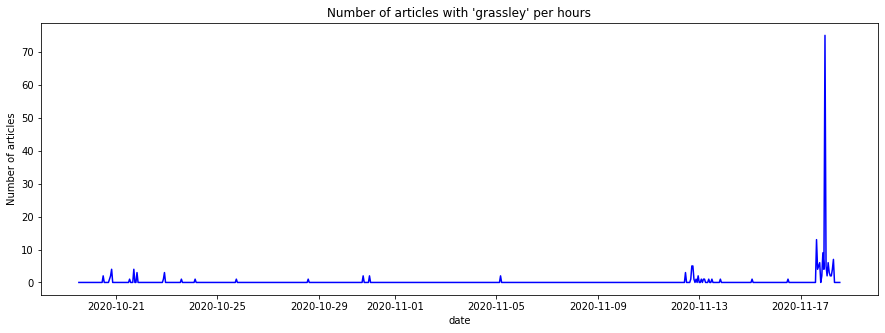

best pic at: 2020-11-17 23:00:00 with 75 apparitions
AP  -  sen. grassley, 87, says he tested positive for coronavirus
mercnews  -  sen. grassley, 87, says he is positive for coronavirus
axios  -  gop sen. chuck grassley, 87, tests positive for covid-19


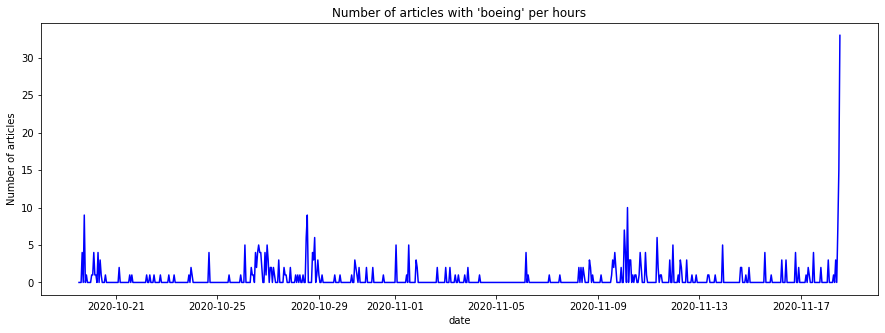

best pic at: 2020-11-18 13:00:00 with 33 apparitions
CNBC  -  faa clears boeing 737 max to fly again after 20-month grounding spurred by deadly crashes
NBCNews  -  faa clears boeing 737 max to fly again
CNBC  -  here are wednesday's biggest analyst calls of the day: boeing, tesla, honeywell & more


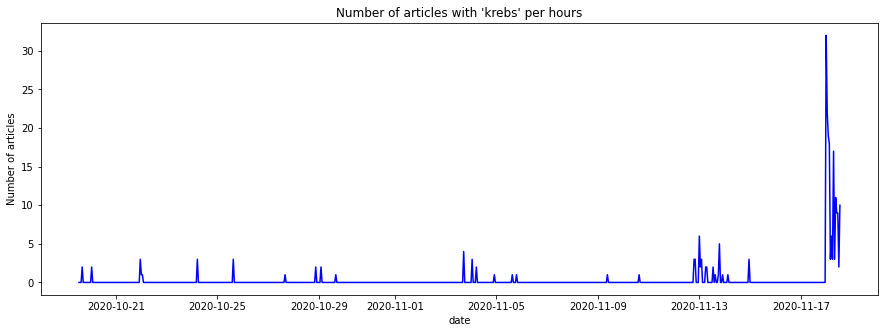

best pic at: 2020-11-18 00:00:00 with 32 apparitions
DEADLINE  -  donald trump fires top homeland security official who refuted claims of voter fraud
elcomercio_peru  -  loreto: buque raumis llegará a 14 comunidades nativas por primera vez llevando atención médica y trámites de reniec
reviewjournal  -  trump fires head of dhs election security agency


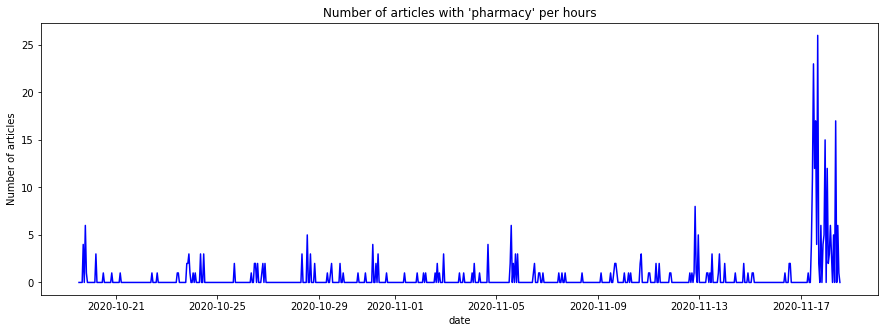

best pic at: 2020-11-17 16:00:00 with 26 apparitions
Gizmodo  -  bleak: amazon is a pharmacy now
NBCNightlyNews  -  amazon now offers online prescription fulfillment, free delivery for prime members
CNBC  -  stocks making the biggest moves midday: tesla, walgreens, draftkings, square and more


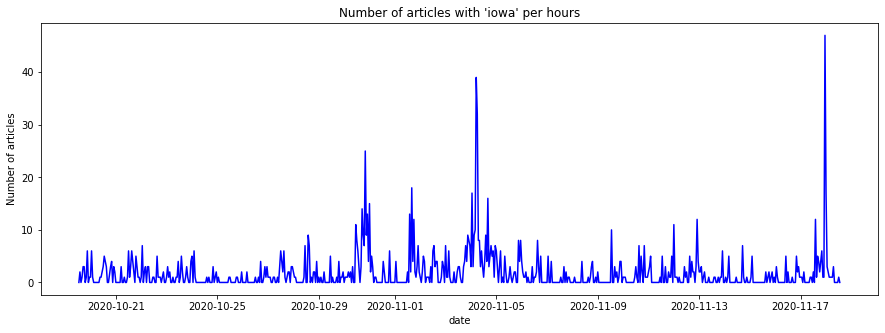

best pic at: 2020-11-17 23:00:00 with 47 apparitions
AP  -  sen. grassley, 87, says he tested positive for coronavirus
PioneerPress  -  gophers men’s basketball to open versus wisconsin-green bay next wednesday
mercnews  -  sen. grassley, 87, says he is positive for coronavirus


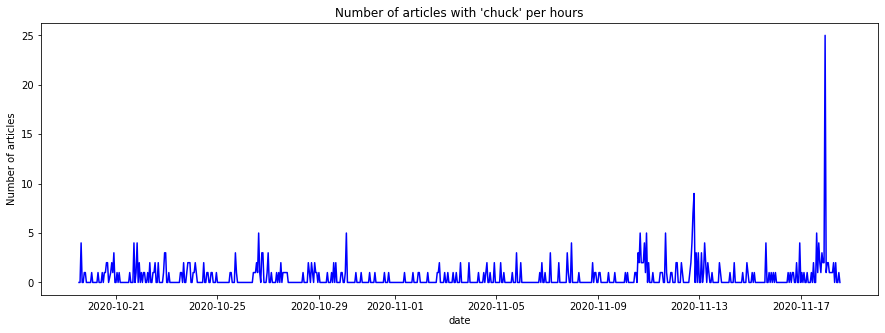

best pic at: 2020-11-17 23:00:00 with 25 apparitions
AP  -  sen. grassley, 87, says he tested positive for coronavirus
mercnews  -  sen. grassley, 87, says he is positive for coronavirus
axios  -  gop sen. chuck grassley, 87, tests positive for covid-19


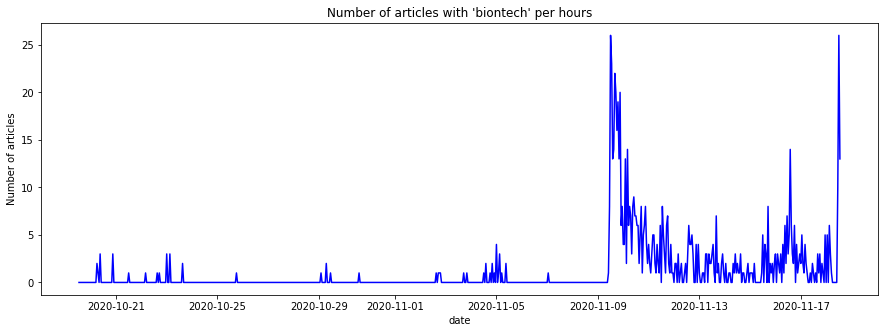

best pic at: 2020-11-18 12:00:00 with 26 apparitions
smh  -  pfizer ends covid-19 vaccine trial with 95 per cent efficacy
LCI  -  en direct - covid-19 : le vaccin pfizer/biontech efficace à 95%, selon des résultats complets de l'essai clinique
diarioas  -  pfizer eleva la efectividad de su vacuna al 95%


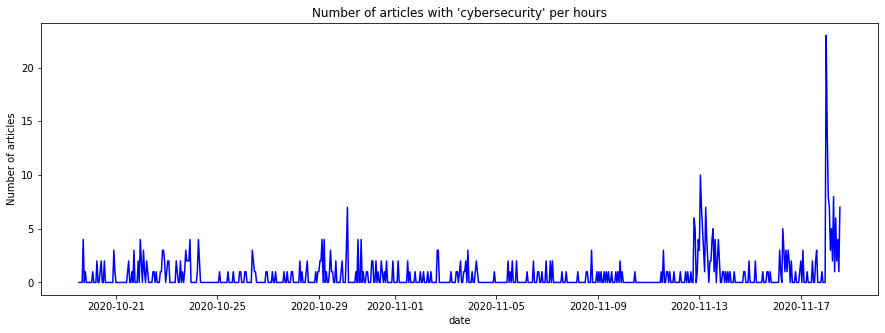

best pic at: 2020-11-18 00:00:00 with 23 apparitions
DEADLINE  -  donald trump fires top homeland security official who refuted claims of voter fraud
reviewjournal  -  trump fires head of dhs election security agency
CGTNOfficial  -  trump fires cybersecurity and infrastructure security agency director


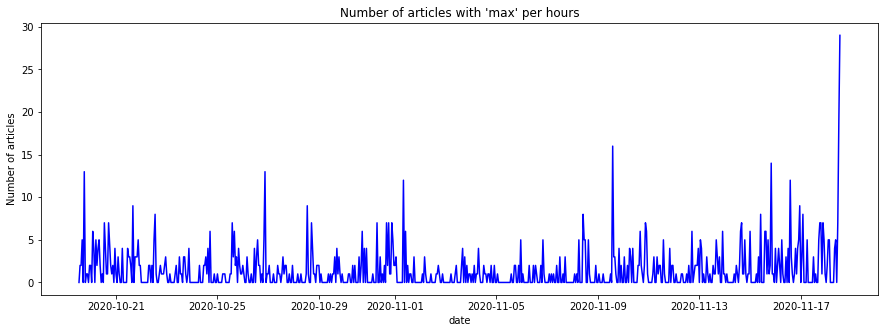

best pic at: 2020-11-18 13:00:00 with 29 apparitions
CNBC  -  faa clears boeing 737 max to fly again after 20-month grounding spurred by deadly crashes
haaretzcom  -  trump and netanyahu are the true democrats | opinion
DiarioPE  -  festival varilux exibe 17 novas produções francesas e o clássico acossado


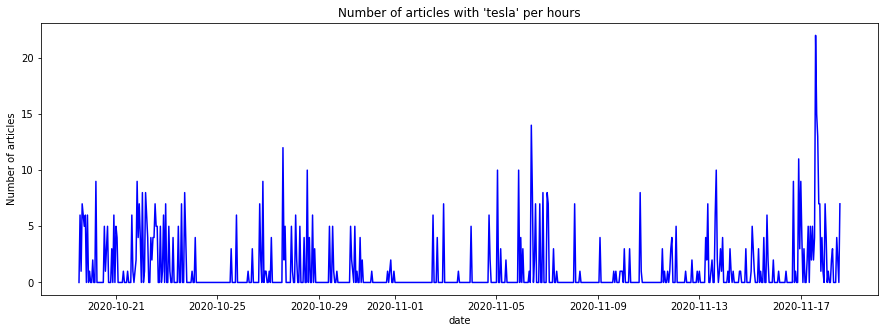

best pic at: 2020-11-17 14:00:00 with 22 apparitions
Estadao  -  tesla vai ingressar em índice s&p 500 e disparar bilhões em negócios - link
FoxBusiness  -  dow dips as home depot falls, tesla up on s&p inclusion
MarketWatch  -  tesla was finally added to the s&p 500. what could come next for its stock.


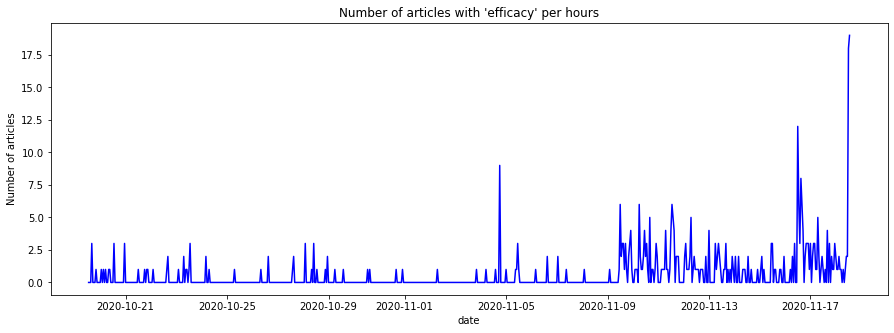

best pic at: 2020-11-18 13:00:00 with 19 apparitions
EconomicTimes  -  coronavirus vaccine live updates: pfizer ends covid-19 trial with 95% efficacy
ReutersWorld  -  q&a: where are we in the covid-19 vaccine race?
Reuters  -  q&a: where are we in the covid-19 vaccine race?


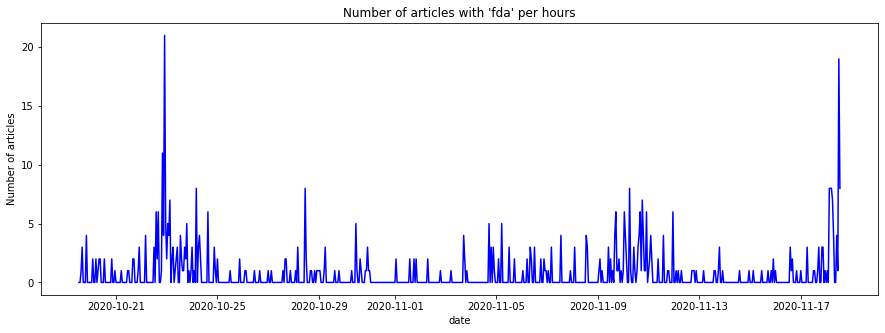

best pic at: 2020-11-18 12:00:00 with 19 apparitions
Tennessean  -  coronavirus updates: pfizer to seek vaccine approval 'within days'; fda grants emergency use for first at-home rapid test
CNBC  -  pfizer says final data analysis shows covid vaccine is 95% effective – plans to submit to fda in 'days'
em_com  -  vacina da pfizer contra covid-19 registrou 95% de eficácia em resultado final


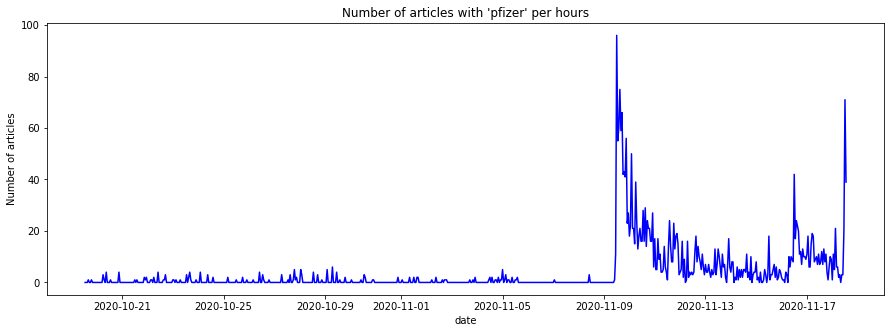

best pic at: 2020-11-18 12:00:00 with 71 apparitions
smh  -  pfizer ends covid-19 vaccine trial with 95 per cent efficacy
LCI  -  en direct - covid-19 : le vaccin pfizer/biontech efficace à 95%, selon des résultats complets de l'essai clinique
IndianExpress  -  coronavirus india live updates: kashmir sero survey finds virus antibodies in 39% people


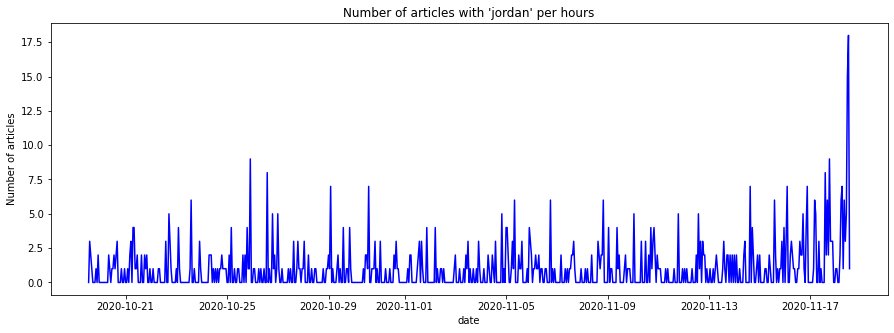

best pic at: 2020-11-18 12:00:00 with 18 apparitions
LCI  -  en direct - covid-19 : le vaccin pfizer/biontech efficace à 95%, selon des résultats complets de l'essai clinique
Daily_Express  -  tess daly warns 'don't get me started' after watching vernon kay's i'm a celebrity trial
NBCNews  -  missing tennessee 9-year-old boy found alive after three day search in woods


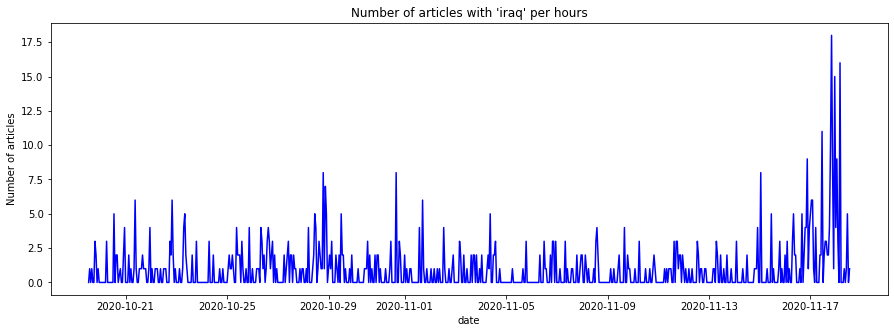

best pic at: 2020-11-17 20:00:00 with 18 apparitions
FinancialReview  -  asx to rise again; tesla soars on s&p 500 inclusion
nypost  -  senate republicans react to trump’s troop withdrawal in afghanistan, iraq
newscomauHQ  -  trump to withdraw thousands of troops from iraq, afghanistan


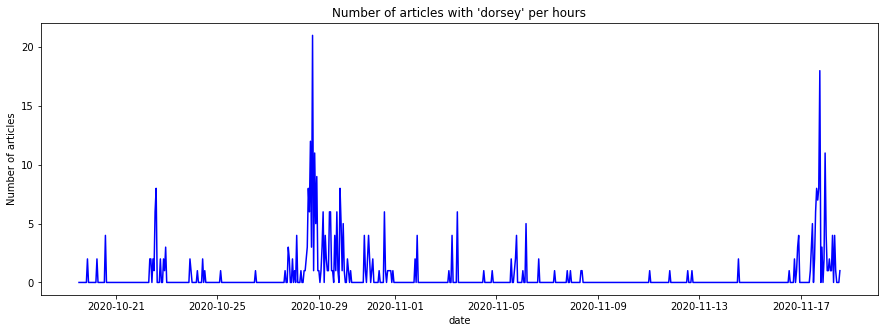

best pic at: 2020-11-17 18:00:00 with 18 apparitions
GuardianAus  -  mark zuckerberg and jack dorsey face senate grilling over tech platforms – live
dcexaminer  -  ted cruz slams twitter ceo over censorship of voter fraud tweets: 'are you an expert on voter fraud?'
CNET  -  facebook, twitter ceos visit congress again: how to watch on tuesday


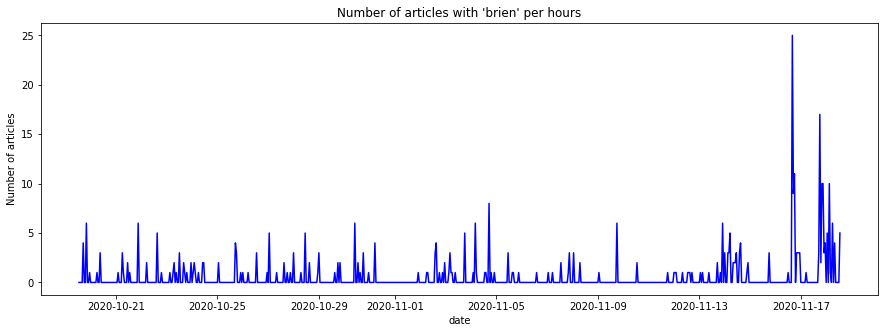

best pic at: 2020-11-17 18:00:00 with 17 apparitions
EW  -  conan o'brien to end talk-show hosting run after 28 years
RollingStone  -  conan o'brien to end tbs late-night show, plots new variety show on hbo max
ABC7Chicago  -  trump to order troop cuts in afghanistan, iraq: sources


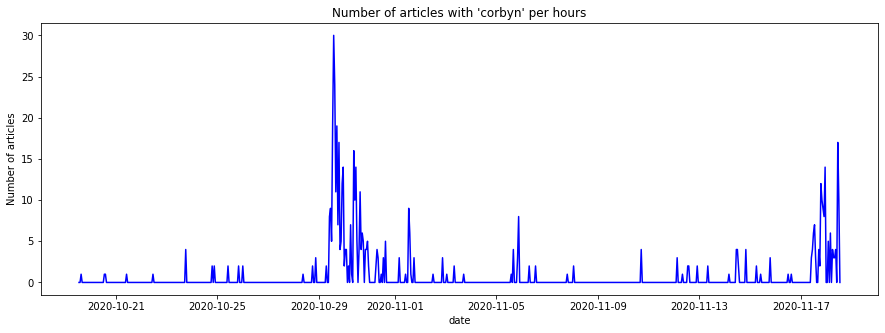

best pic at: 2020-11-18 11:00:00 with 17 apparitions
BBCPolitics  -  virtual prime minister's questions
guardian  -  uk politics live: starmer says corbyn 'undermined' party on antisemitism and refuses to restore labour whip
SkyNews  -  jeremy corbyn won't have labour whip restored, says sir keir starmer


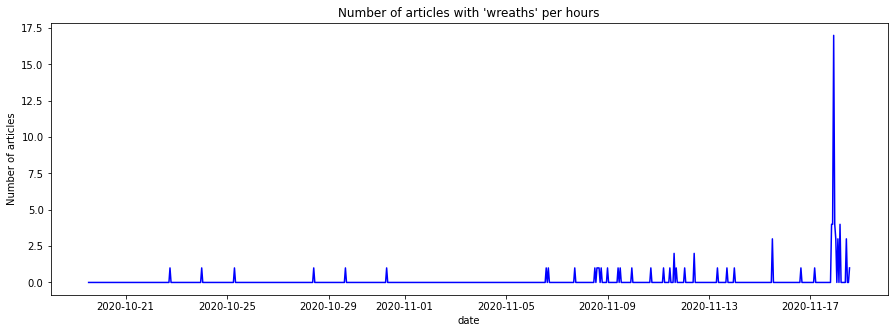

best pic at: 2020-11-17 22:00:00 with 17 apparitions
ABC7Chicago  -  army secretary overrules arlington national cemetery decision to cancel wreaths across america event due to covid-19
ABC7NY  -  army secretary overrules arlington national cemetery decision to cancel wreaths across america event due to covid-19
BreitbartNews  -  donald trump reverses cancellation of 'wreaths across america' event at arlington cemetery


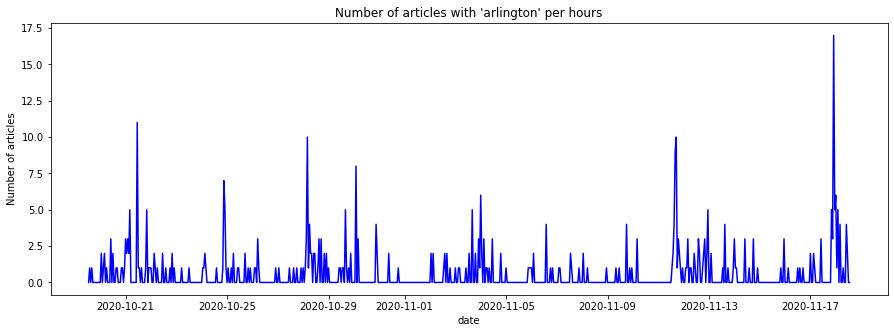

best pic at: 2020-11-17 22:00:00 with 17 apparitions
ABC7Chicago  -  army secretary overrules arlington national cemetery decision to cancel wreaths across america event due to covid-19
ABC7NY  -  army secretary overrules arlington national cemetery decision to cancel wreaths across america event due to covid-19
BreitbartNews  -  donald trump reverses cancellation of 'wreaths across america' event at arlington cemetery


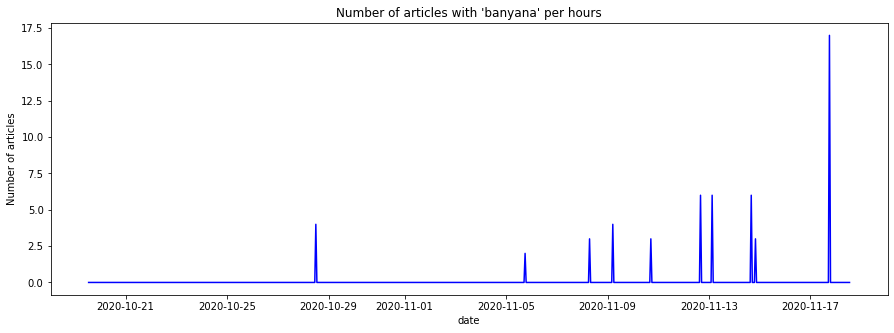

best pic at: 2020-11-17 18:00:00 with 17 apparitions
IOL  -  opinion: safa needs to show banyana the money
SowetanLIVE  -  former banyana stalwart makhosi luthuli dies after a long battle with cancer
SowetanLIVE  -  plans underway to pay bafana bafana and banyana banyana same amount


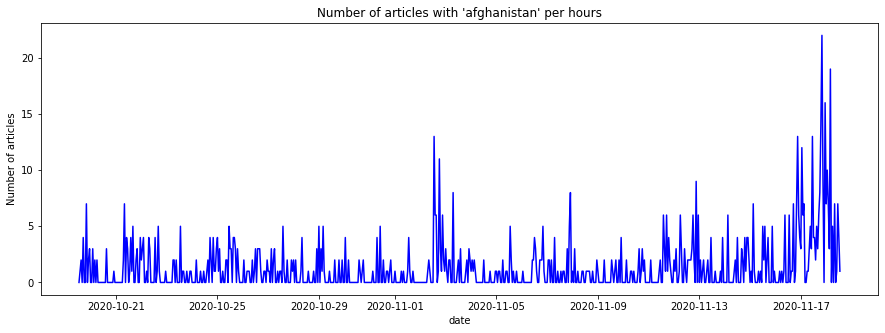

best pic at: 2020-11-17 20:00:00 with 22 apparitions
FinancialReview  -  asx to rise again; tesla soars on s&p 500 inclusion
nypost  -  senate republicans react to trump’s troop withdrawal in afghanistan, iraq
MSNBC  -  republicans finally find a post-election trump move they don't like


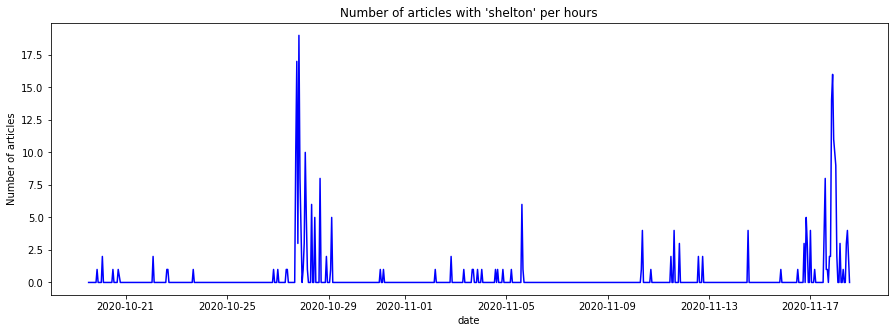

best pic at: 2020-11-17 21:00:00 with 16 apparitions
EastBayTimes  -  controversial fed nominee stalls in the senate
mercnews  -  controversial fed nominee stalls in the senate
stltoday  -  u.s. senate blocks confirmation of trump fed nominee shelton


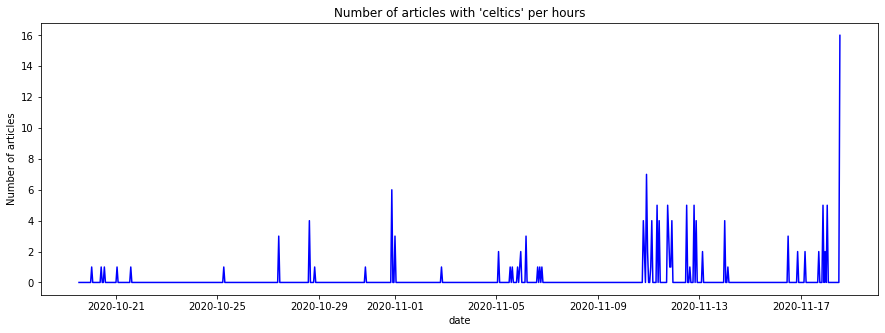

best pic at: 2020-11-18 13:00:00 with 16 apparitions
wbz  -  littleton families asked to pledge they'll follow covid guidelines for thanksgiving
wbz  -  tractor-trailer crash on zakim bridge leads to major traffic delays
NECN  -  is gordon hayward headed to the hawks?


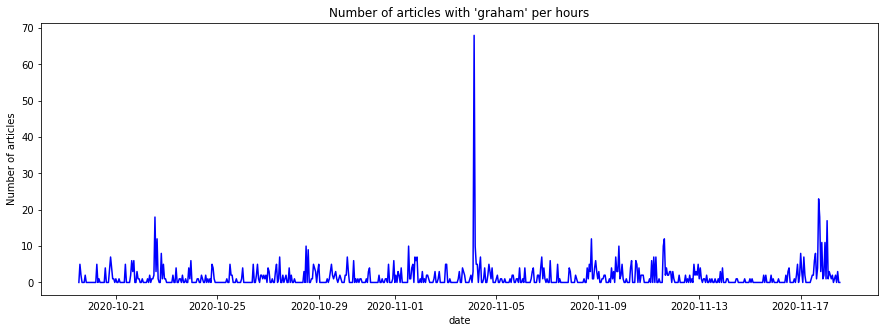

best pic at: 2020-11-17 17:00:00 with 23 apparitions
ABCPolitics  -  twitter: 300,000 tweets flagged over election disinformation
RawStory  -  ‘what the hell is lindsey graham doing?’ cnn analyst shocked by gop senator’s election meddling
CNN  -  georgia secretary of state says lindsey graham implied he should try to throw away ballots


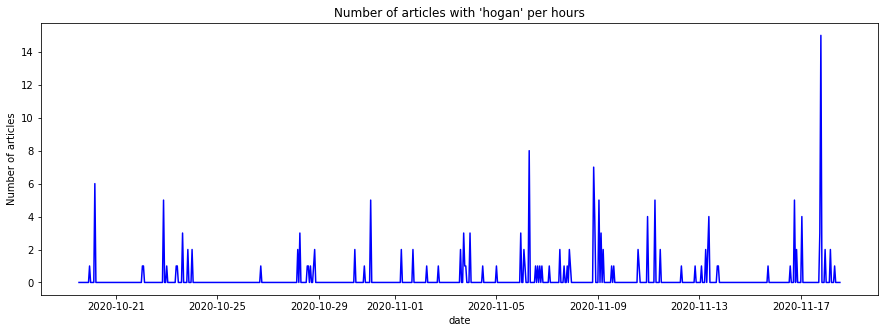

best pic at: 2020-11-17 19:00:00 with 15 apparitions
fox5dc  -  maryland governor larry hogan to announce ‘additional actions’ against covid-19 spread
fox5dc  -  ‘we are in a war right now, and the virus is winning:’ maryland gov hogan announces new covid restrictions
fox5dc  -  maryland governor larry hogan to announce ‘additional actions’ against covid-19 spread


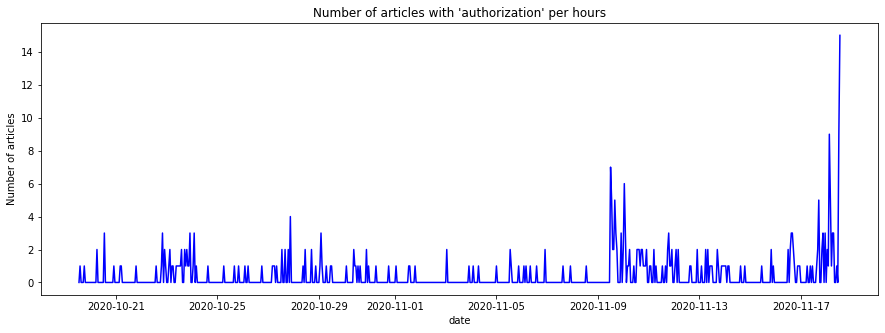

best pic at: 2020-11-18 13:00:00 with 15 apparitions
EconomicTimes  -  coronavirus vaccine live updates: pfizer ends covid-19 trial with 95% efficacy
ReutersWorld  -  q&a: where are we in the covid-19 vaccine race?
Tennessean  -  tennessee among 4 states in pfizer covid-19 vaccine pilot delivery program


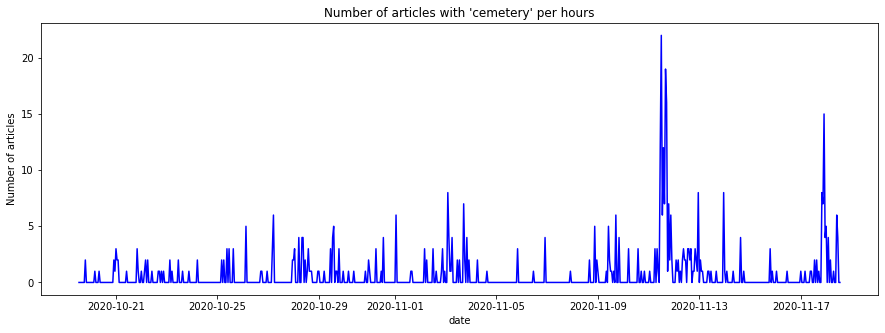

best pic at: 2020-11-17 22:00:00 with 15 apparitions
ABC7Chicago  -  army secretary overrules arlington national cemetery decision to cancel wreaths across america event due to covid-19
ABC7NY  -  army secretary overrules arlington national cemetery decision to cancel wreaths across america event due to covid-19
BreitbartNews  -  donald trump reverses cancellation of 'wreaths across america' event at arlington cemetery


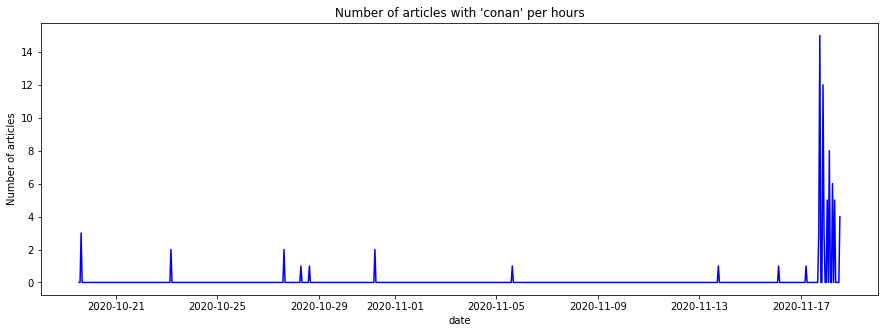

best pic at: 2020-11-17 18:00:00 with 15 apparitions
EW  -  conan o'brien to end talk-show hosting run after 28 years
RollingStone  -  conan o'brien to end tbs late-night show, plots new variety show on hbo max
CNET  -  conan o'brien to end nightly talk show, launch hbo max variety series


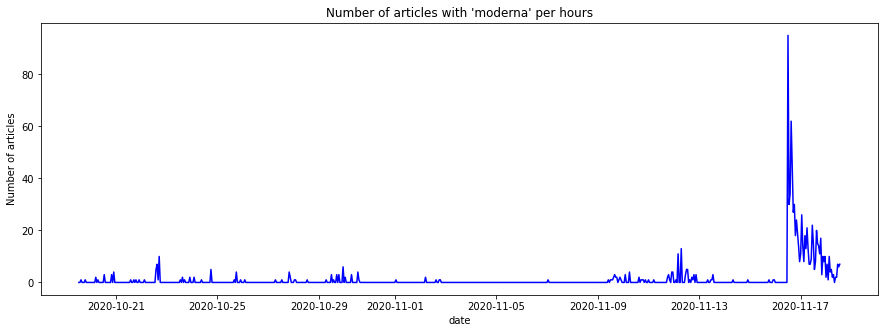

best pic at: 2020-11-17 15:00:00 with 20 apparitions
standardnews  -  uk fund manager baillie gifford made $12 billion on tesla, now $836m on covid vaccines
DailyMailUK  -  uk 'may pay twice as much as the us' for moderna's covid-19 vaccine
ojeconomico  -  vendas a retalho e aumento das restrições à mobilidade nos eua penalizam wall streett


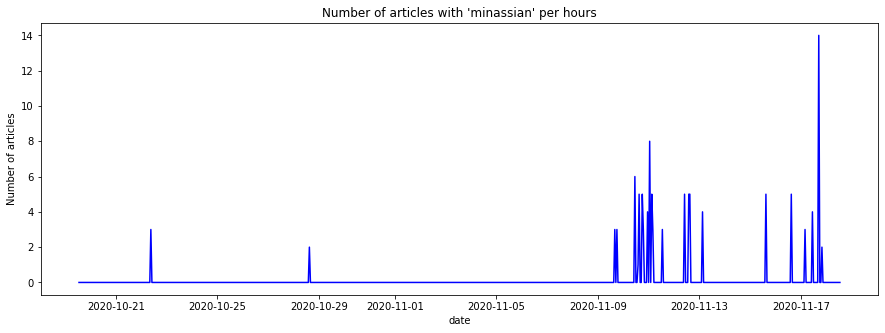

best pic at: 2020-11-17 17:00:00 with 14 apparitions
TheTorontoSun  -  alek minassian's dad denies tailoring evidence to help son in van attack trial
globeandmail  -  alek minassian’s father denies tailoring testimony to help son at van attack trial


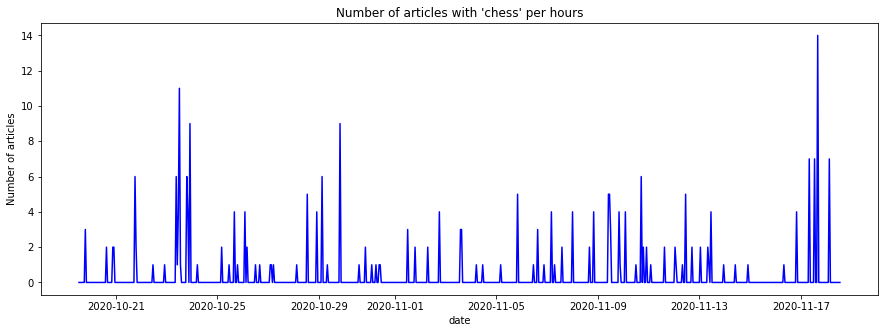

best pic at: 2020-11-17 16:00:00 with 14 apparitions
Slate  -  world chess champion garry kasparov on what the queen’s gambit gets right
BuzzFeedNews  -  the new season of "the crown" spotlights princess diana, and it doesn't disappoint
dailystar  -  bbc breakfast's dan walker humiliated by 8-year-old boy in speed chess match


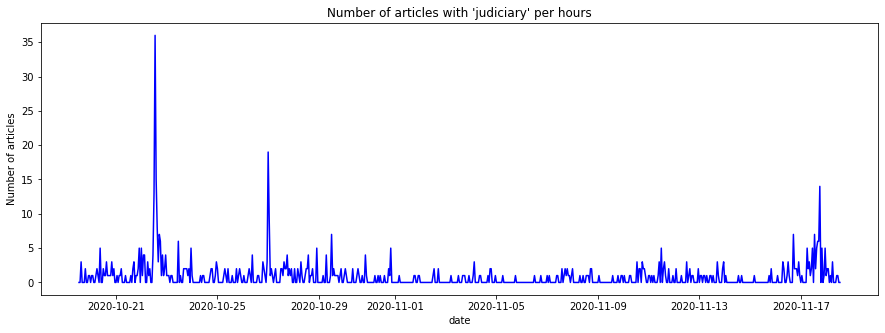

best pic at: 2020-11-17 18:00:00 with 14 apparitions
Newsweek  -  lindsey graham says he discussed election concerns with officials in arizona, nevada—not just georgia
CNET  -  facebook, twitter ceos visit congress again: how to watch on tuesday
bangordailynews  -  twitter: 300,000 tweets flagged over election disinformation


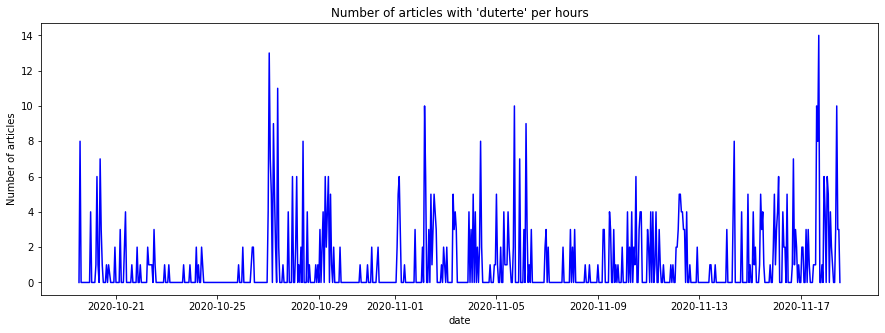

best pic at: 2020-11-17 17:00:00 with 14 apparitions
ABSCBNNews  -  duterte threatens to defund up amid students' protest vs disaster response, pandemic handling
gmanews  -  in rant against robredo, duterte admits his day usually begins at 2 p.m.
gmanews  -  angry over 'nasaan ang pangulo?', duterte low blows leni


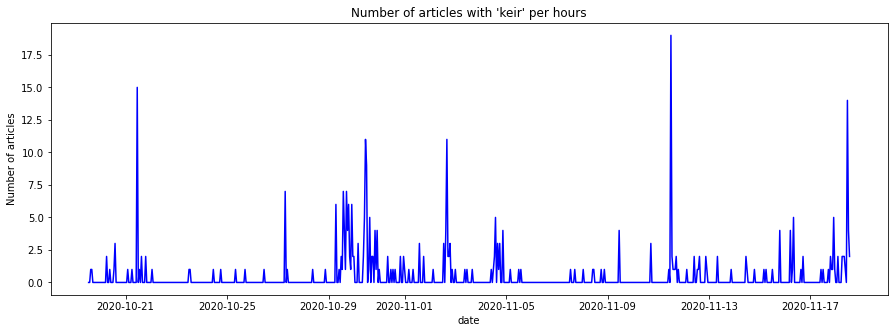

best pic at: 2020-11-18 11:00:00 with 14 apparitions
BBCPolitics  -  virtual prime minister's questions
SkyNews  -  jeremy corbyn won't have labour whip restored, says sir keir starmer
MetroUK  -  keir starmer refuses to give jeremy corbyn whip as he's readmitted to labour


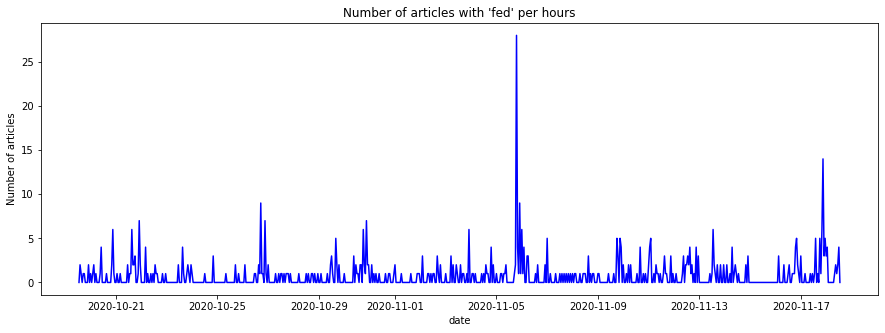

best pic at: 2020-11-17 21:00:00 with 14 apparitions
EastBayTimes  -  controversial fed nominee stalls in the senate
mercnews  -  controversial fed nominee stalls in the senate
stltoday  -  u.s. senate blocks confirmation of trump fed nominee shelton


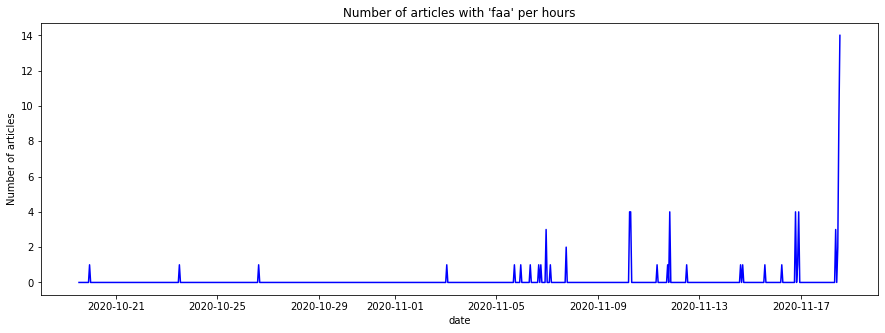

best pic at: 2020-11-18 13:00:00 with 14 apparitions
CNBC  -  faa clears boeing 737 max to fly again after 20-month grounding spurred by deadly crashes
republikaonline  -  polda papua barat telusuri transaksi senjata dari filipina
NBCNews  -  faa clears boeing 737 max to fly again


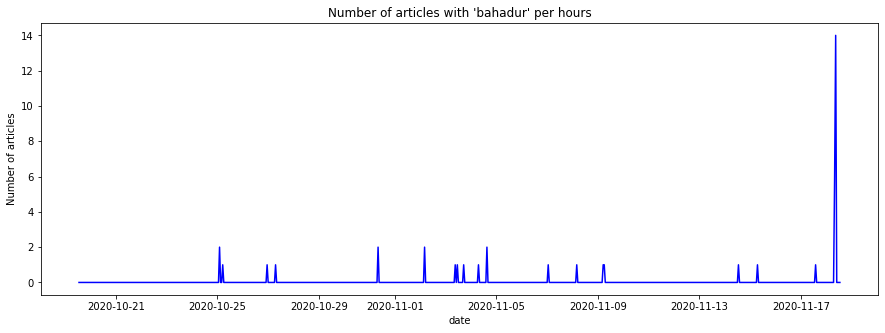

best pic at: 2020-11-18 09:00:00 with 14 apparitions
TOIIndiaNews  -  sc reserves order on tej bahadur's plea against rejection of nomination paper to contest against pm | india news - times of india
IndianExpress  -  sc reserves order on tej bahadur’s plea against rejection of nomination paper to contest against pm
htTweets  -  supreme court reserves order on plea challenging pm modi’s election to varanasi seat


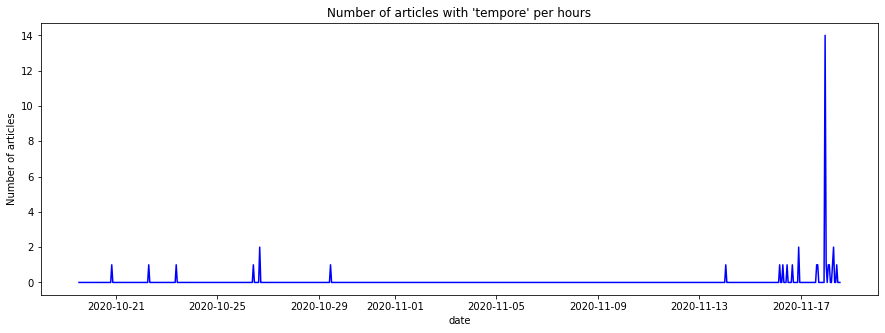

best pic at: 2020-11-17 23:00:00 with 14 apparitions
AP  -  sen. grassley, 87, says he tested positive for coronavirus
mercnews  -  sen. grassley, 87, says he is positive for coronavirus
axios  -  gop sen. chuck grassley, 87, tests positive for covid-19


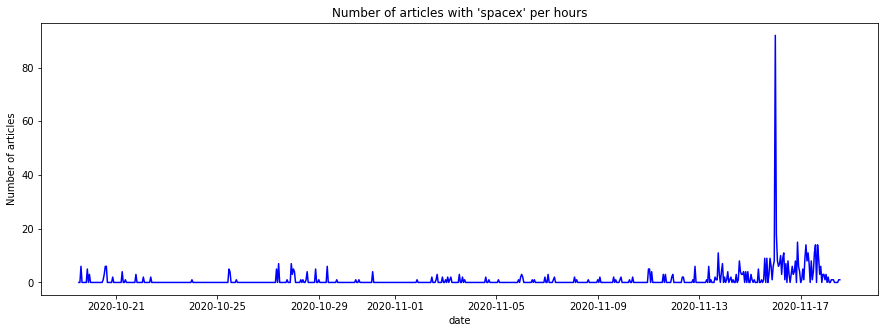

best pic at: 2020-11-17 14:00:00 with 14 apparitions
CBSNews  -  spacex crew dragon capsule chases down and docks with international space station
abc13houston  -  spacex capsule with 4 astronauts reaches space station
NECN  -  spacex capsule with 4 astronauts reaches space station


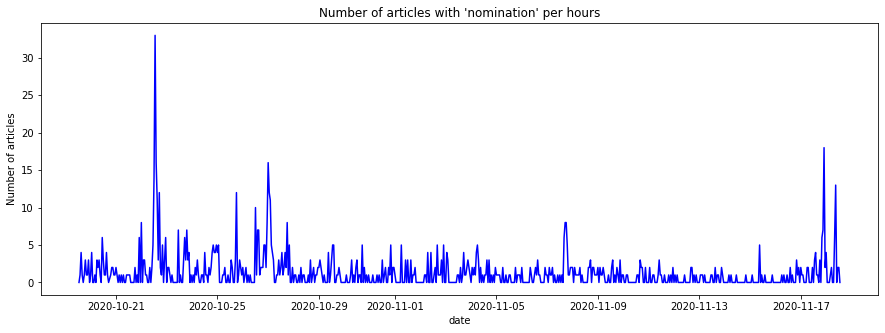

best pic at: 2020-11-17 22:00:00 with 18 apparitions
nytimes  -  biden’s covid advisers say that by blocking the transition, trump may hold up vaccine distribution.
CNBCi  -  shelton fed nomination fails key senate procedure vote, possibly ending her chances
CBSNews  -  senate blocks trump's controversial nominee to federal reserve board


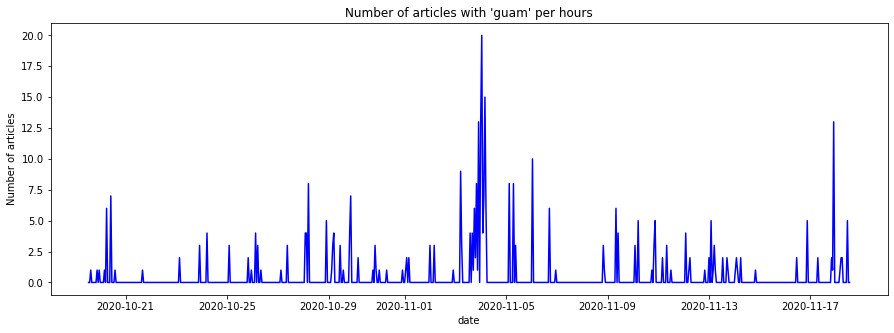

best pic at: 2020-11-17 22:00:00 with 13 apparitions
GuamPDN  -  guam listed among national geographic's top travel destinations for 2021
GuamPDN  -  it&e guam hosts text-to-donate to benefit victims of typhoons rolly and ulysses


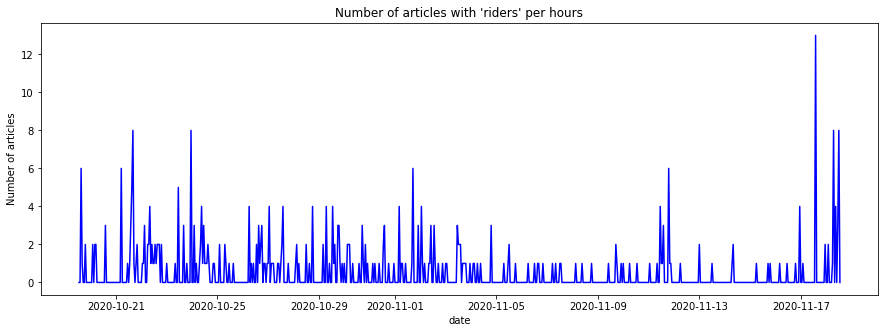

best pic at: 2020-11-17 14:00:00 with 13 apparitions
vanguardngrnews  -  riot at apple junction, festack as okada riders go after task force for seizing their motorcycles
engadget  -  uber's expanded rewards program offers apple music and hbo max perks
vanguardngrnews  -  riot at apple junction, festack as okada riders go after task force for seizing their motorcycles


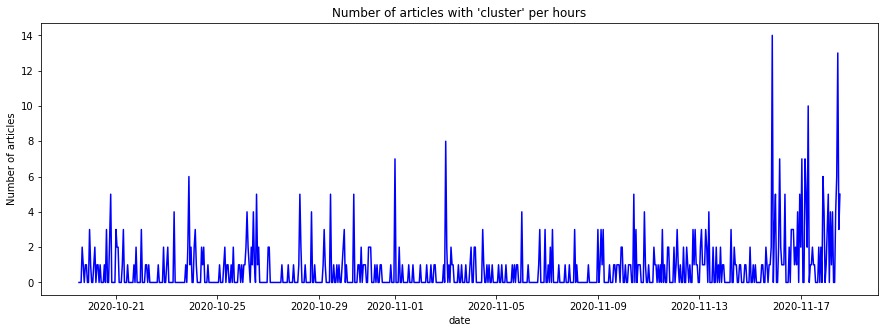

best pic at: 2020-11-18 11:00:00 with 13 apparitions
FinancialXpress  -  2020 hyundai i20 first drive review: india’s most feature-loaded hot hatch
dailystar  -  phillip schofield says he 'nearly resigned' from this morning after blunder
ChannelNewsAsia  -  iran feeds uranium gas into advanced centrifuges underground: iaea


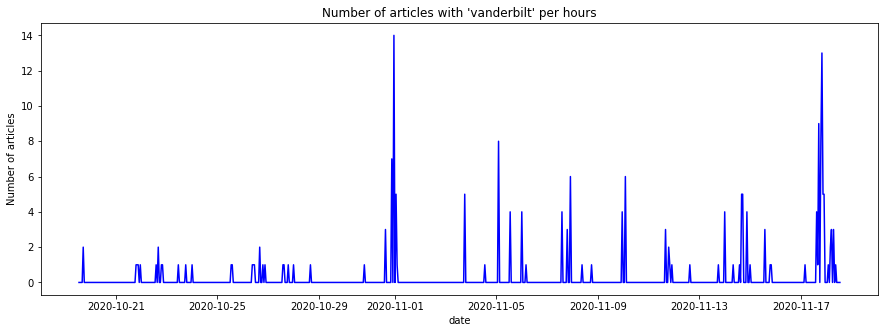

best pic at: 2020-11-17 20:00:00 with 13 apparitions
Tennessean  -  nashville police id suspect in slaying of metro schools math teacher
MarketWatch  -  twitter sings dolly parton’s praises for giving $1 million toward developing moderna’s coronavirus vaccine
Tennessean  -  vanderbilt basketball sets non-conference schedule to open jerry stackhouse's second season


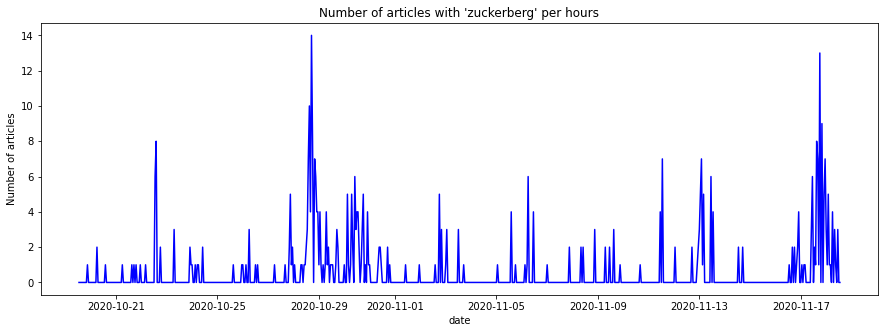

best pic at: 2020-11-17 18:00:00 with 13 apparitions
GuardianAus  -  mark zuckerberg and jack dorsey face senate grilling over tech platforms – live
CNET  -  facebook, twitter ceos visit congress again: how to watch on tuesday
bangordailynews  -  twitter: 300,000 tweets flagged over election disinformation


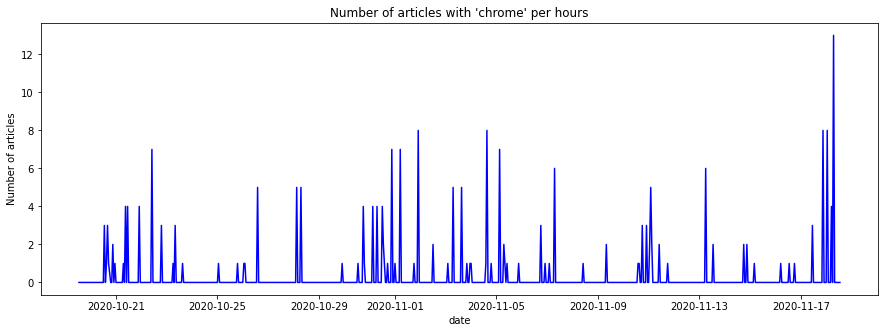

best pic at: 2020-11-18 07:00:00 with 13 apparitions
verge  -  google starts rolling out chrome update with "biggest performance gain in years"
FinancialXpress  -  google says new update brings largest gain in chrome browser performance in years


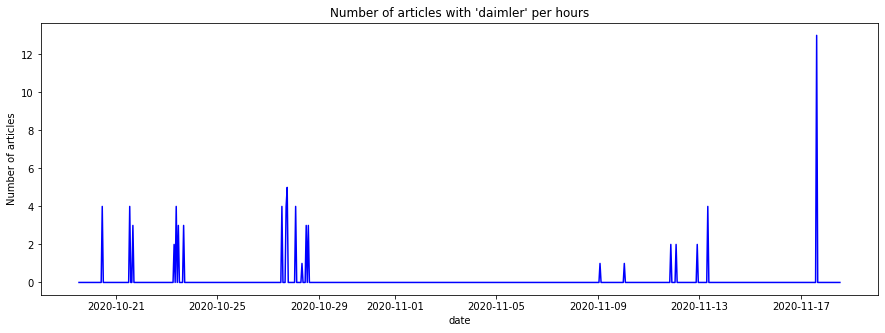

best pic at: 2020-11-17 15:00:00 with 13 apparitions
ChannelNewsAsia  -  daimler to develop next-generation engines with china's geely
ReutersBiz  -  daimler to develop next-generation engines with china's geely


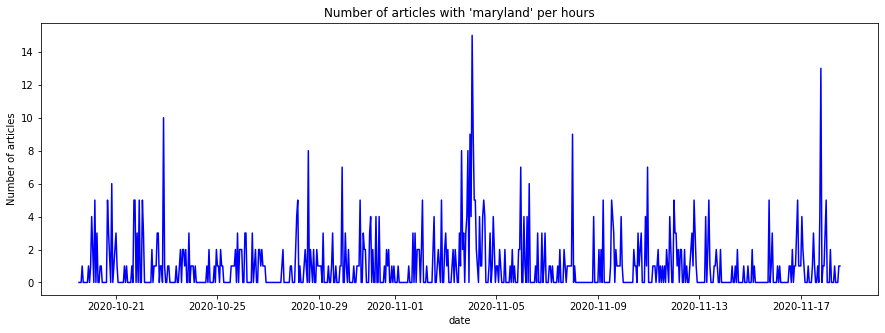

best pic at: 2020-11-17 19:00:00 with 13 apparitions
fox5dc  -  maryland governor larry hogan to announce ‘additional actions’ against covid-19 spread
fox5dc  -  ‘we are in a war right now, and the virus is winning:’ maryland gov hogan announces new covid restrictions
fox5dc  -  maryland governor larry hogan to announce ‘additional actions’ against covid-19 spread


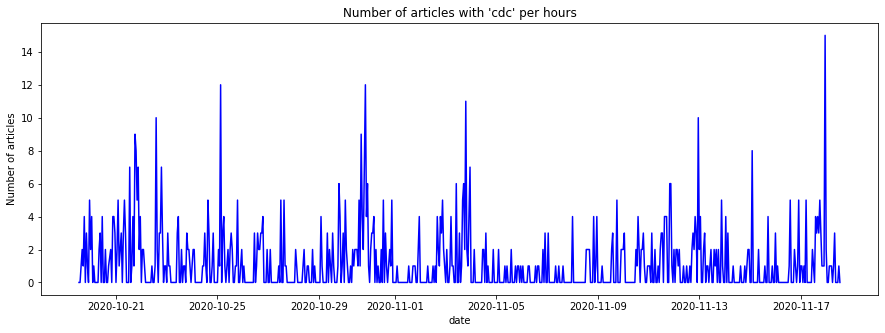

best pic at: 2020-11-17 23:00:00 with 15 apparitions
AP  -  sen. grassley, 87, says he tested positive for coronavirus
mercnews  -  sen. grassley, 87, says he is positive for coronavirus
thehill  -  trumps to spend thanksgiving at white house instead of traveling to florida


In [179]:
plot_best_words(matrix, shift,  word_and_best_datetime_idx[:50], words, dates, data)

### Test with TF-IDF 
##### Create date x handle x words Tf-idf score matrix

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=25000)

def string_to_tfidf(string):
    sparse = vectorizer.transform(["",string])[1]
    array = sparse.toarray()[0]
    tupleslist = []
    for i in sparse.nonzero()[1]:
        tupleslist.append((i, array[i]))
    
    return tupleslist


tfidfScore = data.groupby(['date','handle'])["preproc"].agg(' '.join)
vectorizer.fit(tfidfScore.to_numpy())
tfidfScore = tfidfScore.apply(string_to_tfidf)

print(tfidfScore)

NameError: name 'TfidfVectorizer' is not defined

In [76]:
tfidfScore = tfidfScore.reset_index()
tfidfScore

In [78]:
tfidfScore["handle_id"], handles = tfidfScore["handle"].factorize()
tfidfScore["date_id"], dates = tfidfScore["date"].factorize()

In [79]:
TFIDFmatrix = np.zeros((len(dates), len(handles), 25000), np.int8)

for line in tfidfScore.iloc():
    for (word_index, value) in line["preproc"]:
        TFIDFmatrix[line["date_id"]][line["handle_id"]][word_index] = (value * 256 - 128)
        
TFIDFmatrix.shape

#### Get best words using TfIdf

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [115]:
vectorizer = TfidfVectorizer(max_features=25000)#ngram_range=(1,2))
response = vectorizer.fit_transform(data["preproc"].to_numpy())


In [93]:
feature_names = vectorizer.get_feature_names()

len(feature_names)

5273110

In [110]:
feature_names[5000000]

'veto deal'

In [95]:
sum_score = np.asarray(response.sum(axis=0))[0] 

In [96]:
word_score = list(zip(feature_names, sum_score))

In [97]:
word_score_sorted = sorted(word_score, key=lambda tup: tup[1])[::-1]

In [98]:
best_words= list(map(lambda tup: tup[0], word_score_sorted[0:25000]))

In [99]:
word_score_sorted[0:100]

[('trump', 1612.3527766442246),
 ('said', 1530.0797438329673),
 ('election', 1281.4055524400228),
 ('biden', 1275.8211740798138),
 ('new', 1125.9780963202772),
 ('president', 1109.8684665306873),
 ('covid', 1082.3221250003844),
 ('19', 971.0031978621219),
 ('covid 19', 932.3344909356978),
 ('people', 910.9087302881155),
 ('state', 910.6062776500343),
 ('year', 870.1473141903182),
 ('one', 860.0227685333642),
 ('us', 814.1990495388285),
 ('coronavirus', 780.5600391954401),
 ('first', 774.6312121945042),
 ('two', 736.0198317185929),
 ('police', 730.7198536061834),
 ('day', 724.2214969366249),
 ('would', 704.4505815104271),
 ('cases', 691.3491452969758),
 ('time', 690.82543712118),
 ('also', 689.3781954715928),
 ('states', 631.5750259161483),
 ('pandemic', 630.9157174562189),
 ('news', 630.5831449839476),
 ('government', 622.2871892180358),
 ('2020', 611.8074414721036),
 ('last', 606.1304537233432),
 ('joe', 575.0420553164872),
 ('could', 565.8358493639413),
 ('week', 556.1697353219877),
